# Pursuit Evasion Game Evolutionary Algorithm

### Pursuit Evasion Games

Pursuit Evasion Games are a subclass of non-cooperative games. The simplest case includes a pursuer and an evader, which in our case are referred to as the predator and prey respectively. The pursuer's objective is to catch the evader, while the evader must avoid capture. This is a zero-sum game of competing interests. The characteristics of the two players are different. In our experiment we give the predator an advantage in top speed, whereas the prey has an agility advantage, encoded as having a higher acceleration. 

### Game Structure
The game has been defined in the `00_Deterministic` notebook, where we also added functionality to simulate, plot, and perform signal processing through discrete cosine transform. The purpose of `00_Deterministic` is to explore the different behaviors that can emerge from this Differential Game. In the next section we will take this game, tweak its architecture and propose an evolutionary algorithm to find the predator and prey's best parameters.

In [1]:
# imports
import numpy as np
import random
import matplotlib.pyplot as plt
from typing import List, Tuple

from utility_EA import *

## Genomes

The first step to evolution is a basic structure to hold the genetic information of the individuals. For this reason, a unqiue genome needs to be defined for the prey and predator. 

**Predator** \
The predator has the max speed and acceleration parameters, to find the best speed and acceleration combination, as well as a `predicition_factor`, which could be described as how much to look ahead at where the prey could be, and finally a `pursuit_strategy`, what the best way to follow the prey is.

**Prey** \
The prey also has the max speed and acceleration parameters, but is also equipped with the ability to change its `reaction_radius`, how close the predator has to be for it to start evading, and its `evasion_angle`, the direction the prey will take to evade.

In [2]:
class PredatorGenome:
    def __init__(self):
        self.max_speed = 0.0
        self.max_acceleration = 0.0

        #self.prediction_factor = 0.0
        #self.pursuit_strategy = 0.0

class PreyGenome:
    def __init__(self):
        self.max_speed = 0.0
        self.max_acceleration = 0.0

        self.react_radius = 0.0
        self.evasion_angle = 0.0

        # experiment with evasion strategy ?

## Fitness Function

The next important part of an evolutionary algorithm is the fitness function, to quantify how well the current genetic combination of prey and predator are performing. This metric will be important in deciding the "survival of the fittest", the best genomes that will go on to reproduce and create the new offspring of agents. Again, we will need a unique way of assessing the fitness of predators and prey, as they have distinct, and competing, interests.

**Predator** \
The predator's goal is to catch the prey, so we can start by giving the predator `0` reward if the prey is not caught within the allotted time or distance. From this, a natural fitness measure could be the `capture_time`, where the lower this value is, the better the predator's performance. In addition, we could also look at the predator's `pursuit_efficiency`, which is defined by dividing the straight line distance between the predator's initial position and the eventual capture, and the distance that the predator actual travelled within the simulation.

**Prey** \  
For the prey there are a few metrics that could help us understand how well it is evading its pursuer. For one, `survival_time` is crucial, because the longer the prey evades capture, the more effectively it is out of reach of the predator's hungry fangs. We could also look at `total_distance` travelled, which would tell us how far the prey got before it was taken down. Another metric could be a calculation of the `average_distance` the prey was able to keep between itself and the predator. One can imagine that a few strategies may arise for the prey, namely, getting as far away from the predator, and maintaining that distance, but also being just out of reach for the predator, making use of its agility. Because of this, we will be implementing a more nuanced fitness function, rewarding both distance and time away from the predator.

In [3]:
# Predator Fitness
def predator_fitness(simulation_result, w_time=0.5, w_eff=0.5):
    if not simulation_result.prey_captured:
        return 0.0 # no capture, no reward
    
    capture_time = 1.0 / (simulation_result.steps_until_capture * simulation_result.params['dt'])

    # straight-line distance from start to prey capture
    start_pos = simulation_result.state[0, 0, 0, :]
    capture_pos = simulation_result.state[simulation_result.steps_until_capture, 0, 0, :]
    optimal_distance = np.linalg.norm(capture_pos - start_pos)
    
    # actual distance traveled
    positions = simulation_result.state[:simulation_result.steps_until_capture, 0, 0, :]
    actual_distance = np.sum(np.linalg.norm(positions[1:] - positions[:-1], axis=1))
    pursuit_efficiency = optimal_distance / actual_distance

    return (capture_time * w_time) + (pursuit_efficiency * w_eff)

# Prey Fitness
def prey_fitness(simulation_result, w_surv=0.6, w_avgd=0.2, w_totd=0.2):
    survival_time = simulation_result.steps_until_capture * simulation_result.params['dt']
    avg_distance = np.mean(positive_distance(simulation_result.state))
    prey_positions = simulation_result.state[:, 1, 0, :]
    total_distance = np.sum(np.linalg.norm(prey_positions[1:] - prey_positions[:-1], axis=1))
    
    return (survival_time * w_surv) + (avg_distance * w_avgd) + (total_distance * w_totd)

## Variation Operators

Next we need to define the evolutionary operators, that are needed to generate new candidate solutions. The operators are divided into different types based on their arity, the number of inputs that go into the variation. The selection operator does not have an arity as it acts as more of a filtering operator, selecting a subset out of all individuals that will be able to reproduce.
- $\mathrm{Arity} = 1$: mutation operator
- $\mathrm{Arity} > 1$: recombination operator
- $\mathrm{Arity} = 2$: crossover operator

Our experiment will not be implementing crossover, instead we will focus on selection, mutation, and recombination.

### Selection
Selection is the process of picking individuals from a population to serve as parents for the next generation of offspring. The operator evaluates the fitness of each individual and probabilistically favors those with higher fitness, guiding the evolutionary process toward better solutions. Selection does not modify the individuals themselves but determines which genotypes are allowed to reproduce. It ensures that advantageous traits are more likely to be propagated, while also maintaining genetic diversity to avoid premature convergence.

### Mutation
The mutation is a unary variation operator that is applied to one genotype and delivers a slightly modified mutant, which is referred to as the child or offspring. This operator acts on one genotype and returns another. It causes a small, random variation, which may or may not help improve the fitness of its offspring. These mutations help the species explore new territory in the parameter space, effectively guaranteeing that the space is connected. The element of randomness is essential to its functioning, as well as differentiating it from other unary heuristic operators.

### Recombination
Recombination is a binary variation operator with the role of merging information from two parent genotypes into their offspring genotypes. The choice of what information is merged is stochastic. There is a chance that through recombination, the offspring performs as well, or even worse than the parents. Yet the hope is that in combining parents genotypes, the emerging combination of genomes in the offspring represents an improvement in the fitness of the individual.


In [4]:
def tournament_selection(population, fitness_values, tournament_size=3):
    """
    population: List of individuals
    fitness_values: List of corresponding fitness values
    tournament_size: Number of individuals in each tournament
    """
    selected = []
    for _ in range(len(population)):
        # randomly select tournament_size individuals
        tournament_indices = random.sample(range(len(population)), tournament_size)
        tournament_fitness = [fitness_values[i] for i in tournament_indices]
        
        # best individual from the tournament
        winner_index = tournament_indices[np.argmax(tournament_fitness)]
        selected.append(population[winner_index])
    
    return selected

def mutate_genome(genome, attr_ranges: dict, rate: float = 0.2, strength: float = 0.2):
    """
    genome: The predator genome to mutate
    rate: Probability of each gene being mutated
    strength: Scale of the mutation if it occurs
    attr_ranges: Range of possible values for mutation
    """
    mutated = type(genome)()

    for attr, (min_val, scale) in attr_ranges.items():
        val = getattr(genome, attr)
        if random.random() < rate:
            val += random.gauss(0, strength * scale)
            if min_val is not None:
                val = max(min_val, val)
            if "angle" in attr:  # keep angles in [0, 2π]
                val = val % (2 * np.pi)
        setattr(mutated, attr, val)
    return mutated

predator_ranges = { "max_speed": (0.1, 0.5), "max_acceleration": (0.05, 0.5) } # "prediction_factor": (None, 1), "pursuit_strategy": (None, 1)
prey_ranges = { "max_speed": (0.1, 0.5), "max_acceleration": (0.05, 0.5), "react_radius": (0.5, 1), "evasion_angle": (0, np.pi/4) }

def mutate_predator(genome, rate=0.2, strength=0.2):
    return mutate_genome(genome, predator_ranges, rate, strength)

def mutate_prey(genome, rate=0.2, strength=0.2):
    return mutate_genome(genome, prey_ranges, rate, strength)

def recombine_genome(parent1, parent2, crossover_rate: float, attributes: List[str]):
    child1, child2 = type(parent1)(), type(parent2)()
    for attr in attributes:
        if random.random() < 0.5:
            setattr(child1, attr, getattr(parent1, attr))
            setattr(child2, attr, getattr(parent2, attr))
        else:
            setattr(child1, attr, getattr(parent2, attr))
            setattr(child2, attr, getattr(parent1, attr))
    if random.random() > crossover_rate:
        return parent1, parent2  # no crossover
    return child1, child2

def recombine_predator(p1, p2, rate=0.7):
    return recombine_genome(p1, p2, rate, [
        "max_speed", "max_acceleration" #"prediction_factor", "pursuit_strategy"
    ])

def recombine_prey(p1, p2, rate=0.7):
    return recombine_genome(p1, p2, rate, [
        "max_speed", "max_acceleration", "react_radius", "evasion_angle"
    ])


## Initialize pop

In [5]:
def initialize_predator_population(population_size):
    """
    Initialize predator population with reasonable parameter ranges
    """
    population = []
    for _ in range(population_size):
        genome = PredatorGenome()
        # initial parameters
        genome.max_speed = np.random.uniform(0.5, 2.0)
        genome.max_acceleration = np.random.uniform(0.5, 2.0)
        #genome.prediction_factor = np.random.uniform(0.0, 1.0)
        #genome.pursuit_strategy = np.random.uniform(0.0, 1.0)
        population.append(genome)
    return population

def initialize_prey_population(population_size):
    """
    Initialize prey population with reasonable parameter ranges
    """
    population = []
    for _ in range(population_size):
        genome = PreyGenome()
        # initial parameters
        genome.max_speed = np.random.uniform(0.5, 2.5)  # Potentially faster than predator
        genome.max_acceleration = np.random.uniform(0.3, 1.5)  # Potentially slower acceleration than predator
        genome.react_radius = np.random.uniform(1.0, 5.0)
        genome.evasion_angle = np.random.uniform(0.0, 2 * np.pi)
        population.append(genome)
    return population

## Main evolution loop

In [6]:
def run_simulation(predator_genome, prey_genome, simulation_params):
    """
    Run a single simulation with given predator and prey genomes
    Returns a SimulationResult object with the outcome
    """
    # Set up simulation parameters from genomes
    params = simulation_params.copy()
    params['pred_speed_max'] = predator_genome.max_speed
    params['prey_speed_max'] = prey_genome.max_speed
    params['pred_acc'] = predator_genome.max_acceleration
    params['prey_acc'] = prey_genome.max_acceleration
    params['R_react'] = prey_genome.react_radius
    
    initial_state = get_trajectory(
        deg=prey_genome.evasion_angle * 180 / np.pi,  # Convert to degrees
        n_steps=params['n_steps'],
        prey_speed_max=params['prey_speed_max']
    )
    
    final_state, steps_until_capture = simulate(initial_state, params)
    
    # Create and return simulation result
    result = SimulationResult()
    result.prey_captured = steps_until_capture < params['n_steps']
    result.steps_until_capture = steps_until_capture
    result.state = final_state
    result.params = params
    
    return result

In [7]:
def evaluate_predator_population(predator_population, prey_population, simulation_params, n_prey_per_predator=5):
    """
    Evaluate each predator against multiple random prey
    Return fitness for each predator
    """
    predator_fitness_values = []
    
    for predator in predator_population:
        # Select random prey to test against
        test_prey = random.sample(prey_population, min(n_prey_per_predator, len(prey_population)))
        
        predator_total_fitness = 0
        for prey in test_prey:
            sim_result = run_simulation(predator, prey, simulation_params)
            predator_total_fitness += predator_fitness(sim_result)
        
        # Average fitness across all prey
        predator_fitness_values.append(predator_total_fitness / len(test_prey))
    
    return predator_fitness_values

def evaluate_prey_population(prey_population, predator_population, simulation_params, n_predators_per_prey=5):
    """
    Evaluate each prey against multiple random predators
    Return fitness for each prey
    """
    prey_fitness_values = []
    
    for prey in prey_population:
        # Select random predators to test against
        test_predators = random.sample(predator_population, min(n_predators_per_prey, len(predator_population)))
        
        prey_total_fitness = 0
        for predator in test_predators:
            sim_result = run_simulation(predator, prey, simulation_params)
            prey_total_fitness += prey_fitness(sim_result)
        
        # Average fitness across all predators
        prey_fitness_values.append(prey_total_fitness / len(test_predators))
    
    return prey_fitness_values

In [8]:
# Main evolutionary loop
def evolve(simulation_params, prey_pop_size=50, pred_pop_size=50, generations=100,
           mutation_rate=0.2, mutation_strength=0.2, crossover_rate=0.7):
    """
    Main evolutionary algorithm loop that evolves predator and prey populations
    """
    # Initialize populations
    prey_population = initialize_prey_population(prey_pop_size)
    pred_population = initialize_predator_population(pred_pop_size)
    
    # Track history of best fitness in each generation
    prey_fitness_history = []
    pred_fitness_history = []
    best_prey_history = []
    best_pred_history = []
    
    for generation in range(generations):
        print(f"Generation {generation+1}/{generations}")
        
        # Evaluate fitness
        prey_fitness_values = evaluate_prey_population(prey_population, pred_population, simulation_params)
        pred_fitness_values = evaluate_predator_population(pred_population, prey_population, simulation_params)
        
        # Store best fitness and individuals
        best_prey_idx = np.argmax(prey_fitness_values)
        best_pred_idx = np.argmax(pred_fitness_values)
        
        prey_fitness_history.append(prey_fitness_values[best_prey_idx])
        pred_fitness_history.append(pred_fitness_values[best_pred_idx])
        
        # Store copies of the best individuals
        best_prey = PreyGenome()
        best_prey.max_speed = prey_population[best_prey_idx].max_speed
        best_prey.max_acceleration = prey_population[best_prey_idx].max_acceleration
        best_prey.react_radius = prey_population[best_prey_idx].react_radius
        best_prey.evasion_angle = prey_population[best_prey_idx].evasion_angle
        best_prey_history.append(best_prey)
        
        best_pred = PredatorGenome()
        best_pred.max_speed = pred_population[best_pred_idx].max_speed
        best_pred.max_acceleration = pred_population[best_pred_idx].max_acceleration
        #best_pred.prediction_factor = pred_population[best_pred_idx].prediction_factor
        #best_pred.pursuit_strategy = pred_population[best_pred_idx].pursuit_strategy
        best_pred_history.append(best_pred)
        
        # Print progress
        print(f"  Best prey fitness: {prey_fitness_history[-1]:.4f}")
        print(f"  Best predator fitness: {pred_fitness_history[-1]:.4f}")
        
        # Select parents using tournament selection
        prey_parents = tournament_selection(prey_population, prey_fitness_values)
        pred_parents = tournament_selection(pred_population, pred_fitness_values)
        
        # Create new generation with recombination and mutation
        new_prey_population = []
        new_pred_population = []
        
        # Generate new prey population
        for i in range(0, prey_pop_size, 2):
            # Select two parents
            parent1 = prey_parents[i % len(prey_parents)]
            parent2 = prey_parents[(i + 1) % len(prey_parents)]
            
            # Create offspring through recombination
            child1, child2 = recombine_prey(parent1, parent2, crossover_rate)
            
            # Mutate offspring
            child1 = mutate_prey(child1, mutation_rate, mutation_strength)
            child2 = mutate_prey(child2, mutation_rate, mutation_strength)
            
            # Add to new population
            new_prey_population.append(child1)
            if len(new_prey_population) < prey_pop_size:
                new_prey_population.append(child2)
        
        # Generate new predator population
        for i in range(0, pred_pop_size, 2):
            # Select two parents
            parent1 = pred_parents[i % len(pred_parents)]
            parent2 = pred_parents[(i + 1) % len(pred_parents)]
            
            # Create offspring through recombination
            child1, child2 = recombine_predator(parent1, parent2, crossover_rate)
            
            # Mutate offspring
            child1 = mutate_predator(child1, mutation_rate, mutation_strength)
            child2 = mutate_predator(child2, mutation_rate, mutation_strength)
            
            # Add to new population
            new_pred_population.append(child1)
            if len(new_pred_population) < pred_pop_size:
                new_pred_population.append(child2)
        
        # Elitism: keep the best individual from previous generation
        new_prey_population[0] = best_prey
        new_pred_population[0] = best_pred
        
        # Replace populations
        prey_population = new_prey_population
        pred_population = new_pred_population
    
    return prey_population, pred_population, prey_fitness_history, pred_fitness_history, best_prey_history, best_pred_history

Generation 1/30
  Best prey fitness: 11.8513
  Best predator fitness: 0.3850
Generation 2/30
  Best prey fitness: 12.8916
  Best predator fitness: 0.0131
Generation 3/30
  Best prey fitness: 12.7284
  Best predator fitness: 0.0142
Generation 4/30
  Best prey fitness: 12.7638
  Best predator fitness: 0.0000
Generation 5/30
  Best prey fitness: 12.9535
  Best predator fitness: 0.0000
Generation 6/30
  Best prey fitness: 12.8355
  Best predator fitness: 0.0000
Generation 7/30
  Best prey fitness: 12.9081
  Best predator fitness: 0.0000
Generation 8/30
  Best prey fitness: 13.1204
  Best predator fitness: 0.0000
Generation 9/30
  Best prey fitness: 12.9927
  Best predator fitness: 0.0000
Generation 10/30
  Best prey fitness: 12.9694
  Best predator fitness: 0.0000
Generation 11/30
  Best prey fitness: 13.1394
  Best predator fitness: 0.0000
Generation 12/30
  Best prey fitness: 13.2548
  Best predator fitness: 0.0000
Generation 13/30
  Best prey fitness: 13.8549
  Best predator fitness: 0.

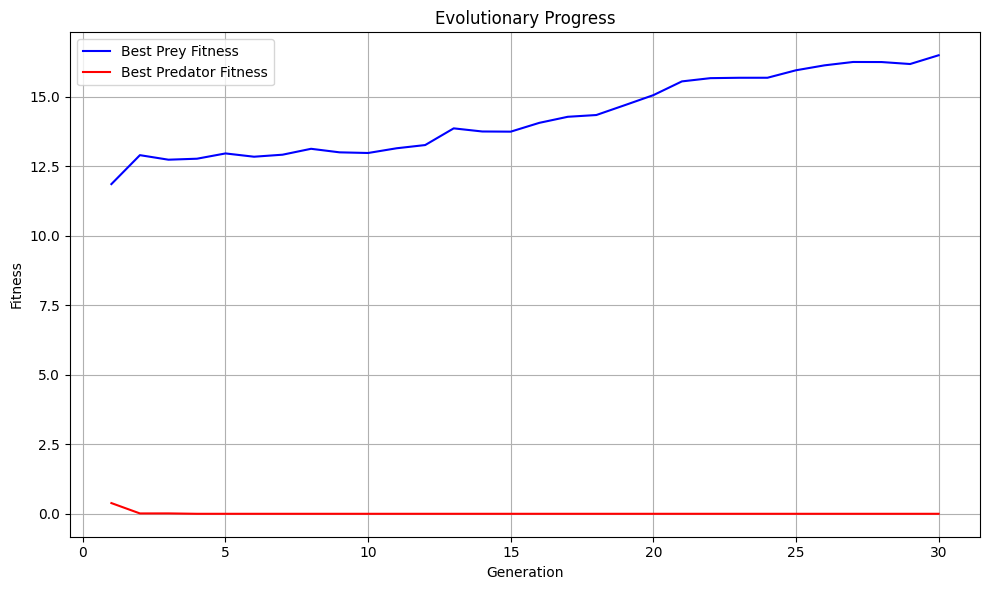


Best Predator:
  Max Speed: 1.64
  Max Acceleration: 1.92

Best Prey:
  Max Speed: 3.98
  Max Acceleration: 0.43
  Reaction Radius: 3.70
  Evasion Angle: 3.61 rad = 207.1°


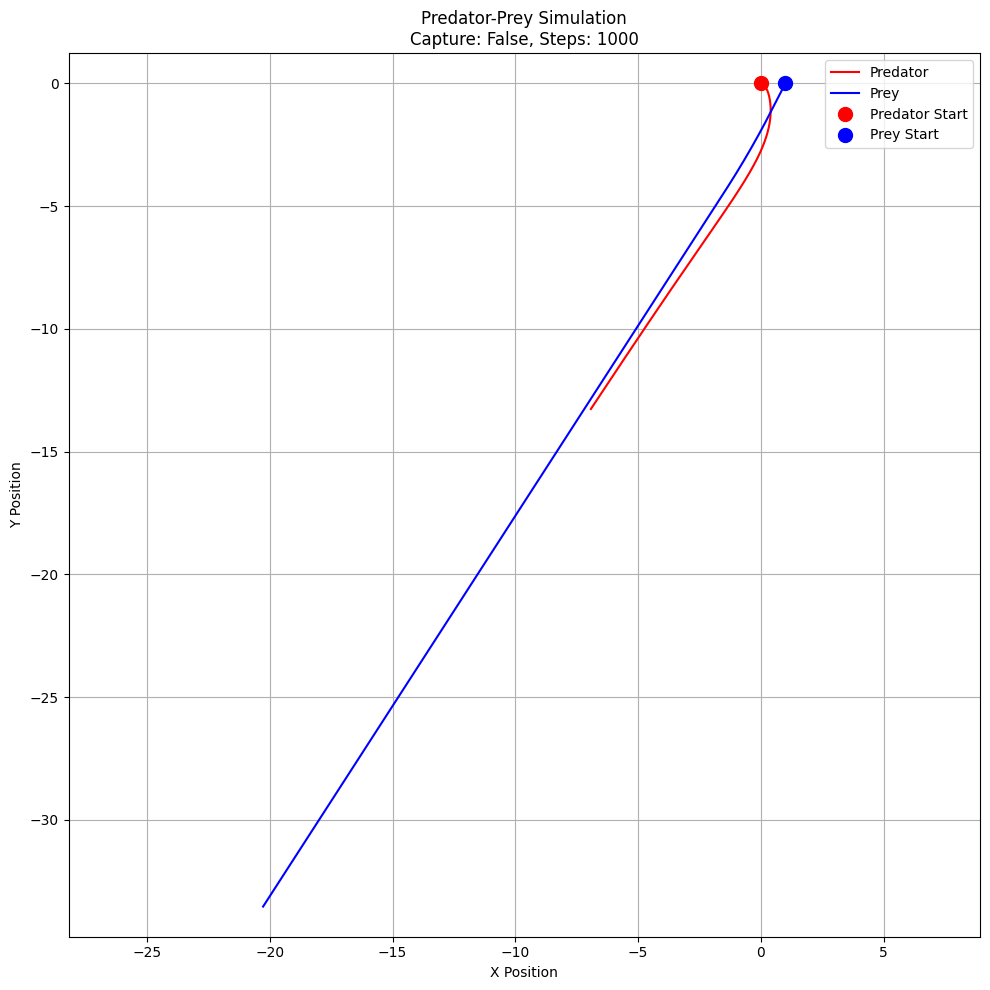

In [9]:
simulation_params = {
        'n_steps': 1000,
        'dt': 0.01,
        'R_kill': 0.1,  # Distance at which prey is considered captured
        'R_react': 2.0,  # Default reaction radius (will be overridden by prey genome)
        'pred_acc': 1.0,  # Default predator acceleration (will be overridden by predator genome)
        'prey_acc': 0.8,  # Default prey acceleration (will be overridden by prey genome)
        'pred_speed_max': 1.5,  # Default predator max speed (will be overridden by predator genome)
        'prey_speed_max': 2.0   # Default prey max speed (will be overridden by prey genome)
    }
    
# Run evolution with smaller populations for quicker testing
prey_pop, pred_pop, prey_history, pred_history, best_prey_history, best_pred_history = evolve(
simulation_params,
prey_pop_size=20,
pred_pop_size=20,
generations=30
)

# Visualize evolution progress
visualize_evolution(prey_history, pred_history)

# Get best individuals from final generation
best_prey = best_prey_history[-1]
best_pred = best_pred_history[-1]

# Print their characteristics
print("\nBest Predator:")
print(f"  Max Speed: {best_pred.max_speed:.2f}")
print(f"  Max Acceleration: {best_pred.max_acceleration:.2f}")
#print(f"  Prediction Factor: {best_pred.prediction_factor:.2f}")
#print(f"  Pursuit Strategy: {best_pred.pursuit_strategy:.2f}")

print("\nBest Prey:")
print(f"  Max Speed: {best_prey.max_speed:.2f}")
print(f"  Max Acceleration: {best_prey.max_acceleration:.2f}")
print(f"  Reaction Radius: {best_prey.react_radius:.2f}")
print(f"  Evasion Angle: {best_prey.evasion_angle:.2f} rad = {best_prey.evasion_angle * 180 / np.pi:.1f}°")

# Visualize a simulation with the best individuals
visualize_best_simulation(best_pred, best_prey, simulation_params)